Code Lab 3: ChestX-ray8, National Institutes of Health Chest X-Ray Dataset
===

These are the materials for the third code lab in Curae.ai's Deep Learning in Healthcare Workshop.

The notebook in this lab is only a baseline notebook meant to help users download the dataset, document its formatting and discuss multi-label classification. Users will compete using this multilabel classification in the Curae.ai DLWH competition. Class is over! You are ready.

# The Problem

In this code lab we will investigate the ChestX-ray8 dataset published by the National Institutes of Health (NIH).  From the paper describing the release of the dataset:
> The chest X-ray is one of the most commonly accessible radiological examinations for screening and diagnosis of many lung diseases. A tremendous number of X-ray imaging studies accompanied by radiological reports are accumulated and stored in many modern hospitals’ Picture Archiving and Communication Systems (PACS). On the other side, it is still an open question how this type of hospital-size knowledge database containing invaluable imaging informatics (i.e., loosely labeled) can be used to facilitate the data-hungry deep learning paradigms in building truly large-scale high precision computer-aided diagnosis (CAD) systems. [1](http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf)

![xray-cover](https://github.com/mike-holcomb/curaeaidlhw-codelab3-chestxray8/blob/master/imgs/chestx-ray8.png?raw=1)

The X-rays in this dataset are each labelled with 14 categories.  In contrast to the other exercises, this represents 14 simultaneous binary classifications for each of the categories.  As an example, an X-ray can contain both an "effusion" and "pneumonia" and would have a "1" for both of these labels.

# Imports

In [0]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
from IPython.display import display, HTML
%matplotlib inline

In [42]:
import tensorflow as tf
tf.enable_eager_execution()

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))
print('Is Eager Execution enabled?: %s' % str(tf.executing_eagerly()))

Tensorflow version:  1.14.0
Is GPU available: False
Is Eager Execution enabled?: True


In [0]:
import tensorflow_hub as hub
from tensorflow.keras import layers

## Load the data

In [0]:
import boto3
import os

s3 = boto3.client('s3',
endpoint_url = 'https://s3.wasabisys.com',
aws_access_key_id = 'VM2WCNG36U812Y1NGCT3',
aws_secret_access_key='g3Dqovv3IYlIFDZyNWONXZSU5yhGZvWhKOJrBQRI')

def download_files(filenames, save_dir):
    for i, filename in enumerate(filenames):
         print('Downloading %d: %s' % (i, filename)) 
         download_file(filename, save_dir)

def download_file(filename, save_dir):
    full_filename = os.path.join(save_dir,filename)
    if os.path.exists(full_filename):
        print('\tAlready have: %s' % full_filename)
        return
    s3.download_file('curaedlhw',filename,full_filename)
    print('\tCOMPLETE: %s saved to %s' % (filename, save_dir))

**NOTE:** Make sure to set the `IS_ONEPANEL` flag to `True` if you are running this notebook from onepanel.io, 

In [0]:
FILELIST = ['chest_xray_train_val.tar.gz']

IS_ONEPANEL = False
NEED_DOWNLOAD = False
if IS_ONEPANEL:
    DATA_DIR='/onepanel/input/datasets/curae/chestx-ray8-mini/1'
else:
    import os
    DATA_DIR = 'data'
    if NEED_DOWNLOAD:
        if not os.path.exists(DATA_DIR):
            os.mkdir(DATA_DIR)
        download_files(FILELIST,DATA_DIR)

os.environ["DATADIR"] = DATA_DIR

In [0]:
!tar xf $DATADIR/chest_xray_train_val.tar.gz -C $DATADIR

In [0]:
meta_file = os.path.join(DATA_DIR,'train_val/train_val.parquet.gz')
meta_df = pd.read_parquet(meta_file)

In [28]:
meta_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,group
index,,,,,,,,,,,,,,,,,,,,,,,,,,
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [32]:
meta_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,group
count,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000
mean,11.495703,14757.351566,48.473725,2668.238903,2480.345808,0.155148,0.155148,0.053818,0.049070,0.255726,0.004082,0.384007,0.112727,0.123555,0.221781,0.102136,0.066601,0.027349,0.032785,0.045052,0.089739,0.107249
std,18.062218,8306.197211,16.678009,332.593252,400.402098,0.016008,0.016008,0.225660,0.216016,0.436273,0.063761,0.486365,0.316262,0.329077,0.415449,0.302830,0.249332,0.163101,0.178075,0.207421,0.285811,0.309433
min,0.000000,1.000000,1.000000,1215.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,8038.250000,37.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,14617.000000,51.000000,2544.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,20907.000000,60.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30795.000000,414.000000,3827.000000,3567.000000,0.198800,0.198800,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
class_map = {'Cardiomegaly': 0,
             'Emphysema': 1,
             'Effusion': 2,
             'Hernia': 3,
             'Infiltration': 4,
             'Mass': 5,
             'Nodule': 6,
             'Atelectasis': 7,
             'Pneumothorax' : 8,
             'Pleural_Thickening': 9,
             'Pneumonia' : 10,
             'Fibrosis' : 11,
             'Edema': 12,
             'Consolidation': 13}
class_list = [''] * 14
for class_name, class_index in class_map.items():
  class_list[class_index] = class_name

In [0]:
def convert_to_label_string(arr):
  label = []
  for i, val in enumerate(arr):
    if val == 1:
      label.append(class_list[i])
  return '|'.join(label)

In [0]:
train_y = meta_df[meta_df['group']==0][class_map.keys()].values
test_y = meta_df[meta_df['group']==1][class_map.keys()].values

In [41]:
print("Size of train set: %d, test set: %d" % (len(train_y),len(test_y)))

Size of train set: 41554, test set: 4992


In [0]:
train_x = meta_df[meta_df['group']==0]['Image Index'].values
test_x = meta_df[meta_df['group']==1]['Image Index'].values

## Build dataloader

In [0]:
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,

    width_shift_range=10,  # randomly shift images horizontally
    height_shift_range=10,  # randomly shift images vertically 
    horizontal_flip=True,  # randomly flip images
) 

eval_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [0]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tensorflow.keras.utils import Sequence

class ChestXraySequence(Sequence):
    def __init__(self, x_set, y_set, batch_size,folder):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.folder = folder

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        img_batch = np.repeat((np.array([ imread(os.path.join(self.folder, file_name),as_gray=True) for file_name in batch_x],
                                         dtype=np.float32)/255.).reshape(self.batch_size,224,224,1),3,3)

        return img_batch, np.array(batch_y)

In [0]:
BATCH_SIZE=32
train_seq = ChestXraySequence(x_set=train_x,
                              y_set=train_y,
                              batch_size=BATCH_SIZE,
                              folder=os.path.join(DATA_DIR,'train_val','images','train'))
test_seq = ChestXraySequence(x_set=train_x,
                              y_set=train_y,
                              batch_size=BATCH_SIZE,
                              folder=os.path.join(DATA_DIR,'train_val','images','test'))

In [0]:
x, y = train_seq[1]

In [243]:
x.shape, y.shape

((32, 224, 224, 3), (32, 14))

## Inspect the data

In [0]:
sample_img, sample_y = x[:10], y[:10]

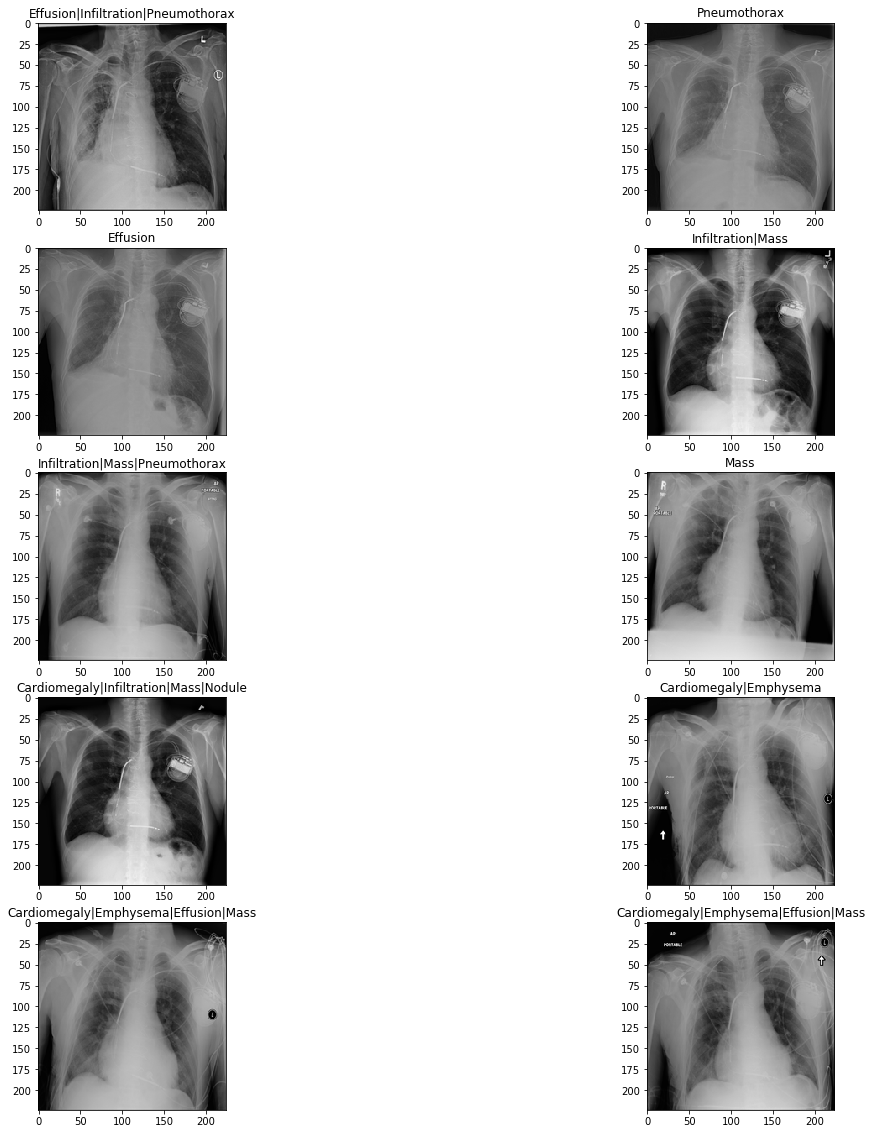

In [231]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
for i, (img, label) in enumerate(zip(sample_img, sample_y)):
    ax[i//2,i%2].title.set_text(convert_to_label_string(label))
    ax[i//2,i%2].imshow(img)

## Baseline Model

In [232]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=False, pooling='avg')
for layer in pretrained_model.layers:
  layer.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [233]:
model = tf.keras.Sequential([
  pretrained_model,
  layers.Dense(len(class_list), activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 14)                17934     
Total params: 2,275,918
Trainable params: 17,934
Non-trainable params: 2,257,984
_________________________________________________________________


## Training

In [0]:
LEARNING_RATE = 0.0001
EPOCHS = 10

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
  loss='binary_crossentropy',
  metrics=['acc'])

In [0]:
save_best = tf.keras.callbacks.ModelCheckpoint('best_model',save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3,min_lr=LEARNING_RATE/1000)
tb_cb = tf.keras.callbacks.TensorBoard(log_dir='/onepanel/output/model3')
hist = tf.keras.callbacks.History()
callbacks = [save_best, early_stopping, reduce_lr, tb_cb, hist]

In [0]:
history = model.fit_generator(train_generator.flow(train_seq,
                                 batch_size=BATCH_SIZE),
                              steps_per_epoch=len(train_seq) / BATCH_SIZE,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              validation_data=eval_generator.flow(test_seq,
                                 batch_size=BATCH_SIZE),
                              validation_steps=len(test_seq) / BATCH_SIZE,
                              max_queue_size=4)